<a href="https://colab.research.google.com/github/sayanbanerjee32/keyword_search/blob/main/Smart_Search_IMDB_fastai_SentPiece.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Create a super smart search engine over any free text data source

This code acompanies the following blog posts by https://medium.com/@thejoshtaylor


In [2]:
%%capture
# To import kaggle datasets
!pip install --upgrade pip 
!pip install kaggle==1.5.6

In [3]:
# import colab libraries
from google.colab import files
# import kaggle json to connect to kaggle user account to download datsets
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"saansd2003","key":"49c2be11dfd314e10999ff432e1eeb65"}'}

In [4]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so lets move it there.
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [5]:
# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
# download our dataset
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews -p 'datasets'

 35% 9.00M/25.7M [00:01<00:02, 6.81MB/s]
100% 25.7M/25.7M [00:01<00:00, 19.7MB/s]


In [7]:
#unzip
!unzip datasets/imdb-dataset-of-50k-movie-reviews.zip -d datasets/

Archive:  datasets/imdb-dataset-of-50k-movie-reviews.zip
  inflating: datasets/IMDB Dataset.csv  


In [8]:
%%capture
!pip install fastai -Uq
!pip install rank_bm25 --quiet #install BM25
!pip install --no-binary :all: nmslib #install nmslib
# !pip install clean-text[gpl]
!pip install sentencepiece

In [1]:
import os
import pandas as pd
import numpy as np
import pickle
import spacy
from tqdm import tqdm
import matplotlib.pyplot as plt
from gensim.models.fasttext import FastText

from rank_bm25 import BM25Okapi
import nmslib
import time
from google.colab import drive

# from cleantext import clean
import re

# drive.mount('/content/drive') # if you want to use G Drive
pd.set_option('display.max_colwidth', -1)
plt.style.use('fivethirtyeight')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [2]:
from fastai.text.all import *

### Load data and create DF

In [3]:
import pandas as pd
df = pd.read_csv('datasets/IMDB Dataset.csv')
df.shape


(50000, 2)

In [4]:
df.head(1)

,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses main...",positive


### Preprocess and tokenise

In [5]:
def fix_text(txt):
    return re.sub(r'(<br />)+','<LINEBREAK>',txt)
    # return clean(txt,
    #             fix_unicode=True,               # fix various unicode errors
    #             to_ascii=True,                  # transliterate to closest ASCII representation
    #             lower=True,                     # lowercase text
    #             no_line_breaks=True,           # fully strip line breaks as opposed to only normalizing them
    #             no_urls=False,                  # replace all URLs with a special token
    #             no_emails=True,                # replace all email addresses with a special token
    #             no_phone_numbers=True,         # replace all phone numbers with a special token
    #             no_numbers=True,               # replace all numbers with a special token
    #             no_digits=False,                # replace all digits with a special token
    #             no_currency_symbols=True,      # replace all currency symbols with a special token
    #             no_punct=True,                 # remove punctuations
    #             replace_with_punct="<PUNCT>",          # instead of removing punctuations you may replace them
    #             replace_with_url="<URL>",
    #             replace_with_email="<EMAIL>",
    #             replace_with_phone_number="<PHONE>",
    #             replace_with_number="<NUMBER>",
    #             replace_with_digit="0",
    #             replace_with_currency_symbol="<CUR>",
    #             lang="en"                       # set to 'de' for German special handling
    #         )

In [6]:
# nlp = spacy.load("en_core_web_sm")
# tok_text=[] # for our tokenised corpus
text = df.review.tolist()
text = [fix_text(str(i)) for i in text]
# spacy = WordTokenizer()
# toks = first(spacy([text]))
# print(coll_repr(toks, 30))

In [8]:
tok = SentencePieceTokenizer()
# SpacyTokenizer()
# tokenizer = Tokenizer(tok)
doc_tok = tokenize_texts(text, tok=tok)
' '.join(doc_tok[0])

"▁xxbos ▁xxmaj ▁one ▁of ▁the ▁other ▁reviewers ▁has ▁mentioned ▁that ▁after ▁watching ▁just ▁1 ▁xxmaj ▁oz ▁episode ▁you ' ll ▁be ▁hooked . ▁xxmaj ▁they ▁are ▁right , ▁as ▁this ▁is ▁exactly ▁what ▁happened ▁with ▁me .< linebreak > the ▁first ▁thing ▁that ▁struck ▁me ▁about ▁xxmaj ▁oz ▁was ▁its ▁brutality ▁and ▁unflinching ▁scenes ▁of ▁violence , ▁which ▁set ▁in ▁right ▁from ▁the ▁word ▁xxup ▁go . ▁xxmaj ▁trust ▁me , ▁this ▁is ▁not ▁a ▁show ▁for ▁the ▁faint ▁hearted ▁or ▁timid . ▁xxmaj ▁this ▁show ▁pulls ▁no ▁punches ▁with ▁regards ▁to ▁drugs , ▁sex ▁or ▁violence . ▁xxmaj ▁its ▁is ▁hardcore , ▁in ▁the ▁classic ▁use ▁of ▁the ▁word .< linebreak > it ▁is ▁called ▁xxup ▁oz ▁as ▁that ▁is ▁the ▁nickname ▁given ▁to ▁the ▁xxmaj ▁oswald ▁xxmaj ▁maximum ▁xxmaj ▁security ▁xxmaj ▁state ▁xxmaj ▁penitent ary . ▁xxmaj ▁it ▁focuses ▁mainly ▁on ▁xxmaj ▁emerald ▁xxmaj ▁city , ▁an ▁experimental ▁section ▁of ▁the ▁prison ▁where ▁all ▁the ▁cells ▁have ▁glass ▁front s ▁and ▁face ▁in ward s , ▁so ▁privacy ▁is 

In [9]:
tok_text = [list(doc_L) for doc_L in doc_tok]
type(tok_text), type(tok_text[0]), tok_text[0][:10]

(list,
 list,
 ['▁xxbos',
  '▁xxmaj',
  '▁one',
  '▁of',
  '▁the',
  '▁other',
  '▁reviewers',
  '▁has',
  '▁mentioned',
  '▁that'])

### Fast text

In [10]:
ft_model = FastText(
    sg=1, # use skip-gram: usually gives better results
    size=100, # embedding dimension (default)
    window=10, # window size: 10 tokens before and 10 tokens after to get wider context
    min_count=5, # only consider tokens with at least n occurrences in the corpus
    negative=15, # negative subsampling: bigger than default to sample negative examples more
    min_n=2, # min character n-gram
    max_n=5 # max character n-gram
)

ft_model.build_vocab(tok_text)

ft_model.train(
    tok_text,
    epochs=6,
    total_examples=ft_model.corpus_count, 
    total_words=ft_model.corpus_total_words)

ft_model.save('_fasttext.model')

### Load fasttext and query

In [11]:
ft_model = FastText.load('_fasttext.model')

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0.0, flags=flags)


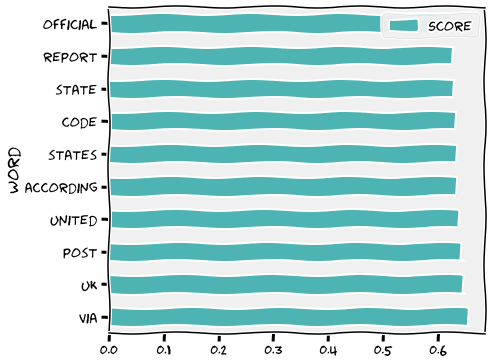

In [12]:
with plt.xkcd():
  pd.DataFrame(ft_model.wv.most_similar("Emerald", topn=10, restrict_vocab=5000),columns=['Word','Score']).plot.barh(x='Word',figsize=(6,6),color=(0.3,0.7,0.7))

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0.0, flags=flags)


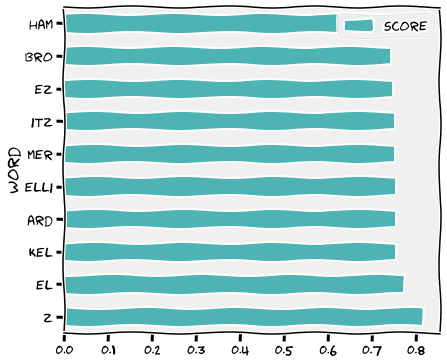

In [13]:
with plt.xkcd():
  pd.DataFrame(ft_model.wv.most_similar("Oz", topn=10, restrict_vocab=10000),columns=['Word','Score']).plot.barh(x='Word',figsize=(6,6),color=(0.3,0.7,0.7))

### Creating BM25 document vectors:

In [14]:
bm25 = BM25Okapi(tok_text)
weighted_doc_vects = []
unknown_words = []
embed_vocab = list(ft_model.wv.vocab.keys())
for i,doc in tqdm(enumerate(tok_text)):
  doc_vector = []
  for word in doc:
    if word in embed_vocab:
        vector = ft_model[word]
        weight = (bm25.idf[word] * ((bm25.k1 + 1.0)*bm25.doc_freqs[i][word])) 
        / 
        (bm25.k1 * (1.0 - bm25.b + bm25.b *(bm25.doc_len[i]/bm25.avgdl))+bm25.doc_freqs[i][word])
        weighted_vector = vector * weight
        doc_vector.append(weighted_vector)
    else: unknown_words.append(word)
  doc_vector_mean = np.mean(doc_vector,axis=0)
  weighted_doc_vects.append(doc_vector_mean)
  len(unknown_words)

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
50000it [14:18, 58.21it/s]


In [15]:
pickle.dump( weighted_doc_vects, open( "weighted_doc_vects.p", "wb" ) )

### Load document vectors, build index and search:

In [16]:
with open( "weighted_doc_vects.p", "rb" ) as f:
    weighted_doc_vects = pickle.load(f)
# create a random matrix to index
data = np.vstack(weighted_doc_vects)

# initialize a new index, using a HNSW index on Cosine Similarity - can take a couple of mins
index = nmslib.init(method='hnsw', space='cosinesimil')
index.addDataPointBatch(data)
index.createIndex({'post': 2}, print_progress=True)

In [17]:
# querying the index:
input = 'Security State Penitentary'


input = fix_text(input).lower().split()

query = [ft_model[vec] for vec in input]
query = np.mean(query,axis=0)

t0 = time.time()
ids, distances = index.knnQuery(query, k=10)
t1 = time.time()
print(f'Searched {df.shape[0]} records in {round(t1-t0,4) } seconds \n')
for i,j in zip(ids,distances):
  print(round(j,2))
  print(df.review.values[i])

Searched 50000 records in 0.0004 seconds 

0.31
I work at a nuclear power plant, so I am getting a kick out of these replies.<br /><br />Seriously, I do. Go to http://en.wikipedia.org/wiki/Palisades_Nuclear_Generating_Station and you can see where I work.<br /><br />I could not think of a safer industry to work in. We are required by procedures to report events as minor as paper cuts. Any issue identified as being a potential concern with respect to nuclear, radiological, or industrial safety is immediately reported in the corrective action process.<br /><br />Bottom line is that nuclear plants in the US operate with safety in the front of their mind.
0.32
The BBC and HBO teamed up to create "Dirty War", a 90 minute TV movie about a terrorist "dirty bomb" attack in London. The film gets down to business quickly as it packs both the terrorist and the government anti-terrorist efforts into the film leaving little room for human interest subplots. On the terrorist side we follow the bomb 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
